In [2]:
import os, sys, time, glob, json, math, warnings, csv
import tifffile as tif
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.spatial.distance as spd
import scipy.cluster as scc
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.spatial.distance import pdist
from scipy.ndimage.interpolation import zoom
from scipy import ndimage

from itertools import chain

In [3]:
# have you run this before? if so, try make_grid = 0 to skip long waits for computing
#else use make_grid = 1
make_grid = 0

In [4]:
# location of your repo clone
sys.path.append("../../..")

In [5]:
# base path
src = "/home/emilyjanedennis/Desktop/"

In [6]:
def get_dists(val,list_of_vals):
    dists = []
    for comp_val in list_of_vals:
        dists.append(math.dist(val,comp_val))
    return dists

In [7]:
def make_heatmap(matrix):
    fig, ax = plt.subplots(figsize=(100,30))
    heatmap = ax.pcolor(matrix, cmap=plt.cm.bone_r)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
    ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

    ax.set_xlim([0, matrix.shape[1]])
    ax.set_ylim([0, matrix.shape[0]])          

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    return fig, ax

In [8]:
def get_dist(original_coords,new_coords):
    tst=np.array(new_coords)
    squared_dist = np.sum((original_coords-tst)**2, axis=0)
    dist = np.sqrt(squared_dist)
    return dist

In [9]:
def get_cosine_sim(vect,matrix_for_comparison):
    #cosine similarity
    list_of_cosines=[]
    for val in matrix_for_comparison:
        list_of_cosines.append(spd.cosine(vect,val))
    cosine_sorted_indices = np.argsort(list_of_cosines)
    cosine_sorted = list_of_cosines.copy()
    cosine_sorted.sort()
    return cosine_sorted

In [10]:
def get_similar_vals_and_save(n,matrix):
    vect=matrix[n]
    matrix_for_comparison=np.array(matrix)

    # find most similar vector(s)
    #cosine similarity
    list_of_cosines=[]
    for val in matrix_for_comparison:
        list_of_cosines.append(spd.cosine(vect,val))
    cosine_sorted_indices = np.argsort(list_of_cosines)
    cosine_sorted = list_of_cosines.copy()
    cosine_sorted.sort()
    num_cosines_to_plot = np.sum([np.array(cosine_sorted) < 0.15])

    # plot
    if num_cosines_to_plot < 4:
        num_cosines_to_plot=4
    cosine_to_plot = matrix_for_comparison[cosine_sorted_indices[0:int(num_cosines_to_plot)]]


    plt.figure(figsize=(10,7))
    for i in np.arange(0,num_cosines_to_plot):
        plt.plot(cosine_to_plot[i],'k',alpha=0.1)
        plt.plot(vect,'k',alpha=0.1)
    plt.title('{} most similar expression patterns \n cosines {}'.format(num_cosines_to_plot,cosine_sorted[0:int(num_cosines_to_plot)]))
    plt.savefig('../../../../../most_similar_to_{}.eps'.format(row_labels[cosine_sorted_indices[0]]))


In [11]:
def get_segmented_and_bool_vols_in_atlvol(cells_floored,bool_cell_vol,segmented_cell_vol,atlvol):
    for i in np.arange(0,np.shape(cells_floored)[0]):
        z,y,x=cells_floored[i]
        try:
            bool_cell_vol[z,y,x]=1
            if atlvol[z,y,x]>0:
                segmented_cell_vol[z,y,x]=atlvol[z,y,x]
        except:
            print("{} failed".format(i))
    return bool_cell_vol, segmented_cell_vol

In [12]:
def get_closest_vals(vect,matrix_for_comparison):

    # find most similar vector(s)
    #cosine similarity
    list_of_cosines=[]
    for val in matrix_for_comparison:
        list_of_cosines.append(spd.cosine(vect,val))
    cosine_sorted_indices = np.argsort(list_of_cosines)
    cosine_sorted = list_of_cosines.copy()
    cosine_sorted.sort()
    num_cosines_to_plot = int(np.sum([np.array(cosine_sorted) < 0.15]))

    # plot
    if num_cosines_to_plot < 4:
        num_cosines_to_plot=4
    cosine_list = cosine_sorted_indices[0:num_cosines_to_plot]
    print(cosine_sorted[0:num_cosines_to_plot])
    cosine_to_plot = matrix_for_comparison[cosine_sorted_indices[0:int(num_cosines_to_plot)]]
    return cosine_list, cosine_to_plot
    

In [13]:
def get_cosine_matrix(input_matrix):
    all_cosines=[]
    list_of_cosines=[]
    for i in np.arange(0,len(input_matrix)):
        list_of_cosines=[]
        val_row=input_matrix[i]
        for row in input_matrix:
            list_of_cosines.append(spd.cosine(row,val_row))
        all_cosines.append(list_of_cosines)
    return all_cosines

# rat in sigma

In [14]:
fld = '/home/emilyjanedennis/Desktop/ratmouse/'

In [15]:
sigma_lab = pd.read_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/SIGMA_in_PRA.csv')

In [16]:
for file in [file for file in os.listdir('/home/emilyjanedennis/Desktop/ratmouse/') if ".tif" in file]:
    tif.imsave('/home/emilyjanedennis/Desktop/max_{}'.format(file),np.amax(tif.imread('/home/emilyjanedennis/Desktop/ratmouse/{}'.format(file)),axis=2))
#check to make sure max projections look sensible (no y flips, good alignment, etc)    


In [17]:
matrix_test=[]
matrix_names=[]
for file_name in os.listdir(fld):
    if "vector" in file_name:
        matrix_test.append(np.load(os.path.join(fld,file_name)))
        matrix_names.append(file_name[0:5])

In [18]:
list_of_elements=[]
for idx in sigma_lab.index:
    if "cere" in sigma_lab.common_name[idx]:
        print(sigma_lab.common_name[idx])
        list_of_elements.append(idx)                              

granule_cell_level_of_the_cerebellum
granule_cell_level_of_the_cerebellum
molecular_layer_of_the_cerebellum
molecular_layer_of_the_cerebellum
cerebellar_peduncle_inferior
cerebellar_peduncle_inferior
middle_cerebellar_peduncle
middle_cerebellar_peduncle
cerebellar_peduncles
cerebellar_peduncles


In [19]:
new_matrix=[]
new_norm_matrix=[]
new_matrix_names=[]
x=-1
for row in matrix_test:
    x=x+1
    for el in list_of_elements:
        row[el]=0
    if x not in [6,9]:
        print(x)
        new_matrix_names.append(matrix_names[x])
        new_matrix.append(row)
        new_norm_matrix.append(np.divide(row,np.max(row)))

0
1
2
3
4
5
7
8
10
11


In [20]:
new_matrix_names

['e144_',
 'z266_',
 'z268_',
 'e142_',
 'j316_',
 'M122_',
 'm128_',
 'z265_',
 'e153_',
 'j319_']

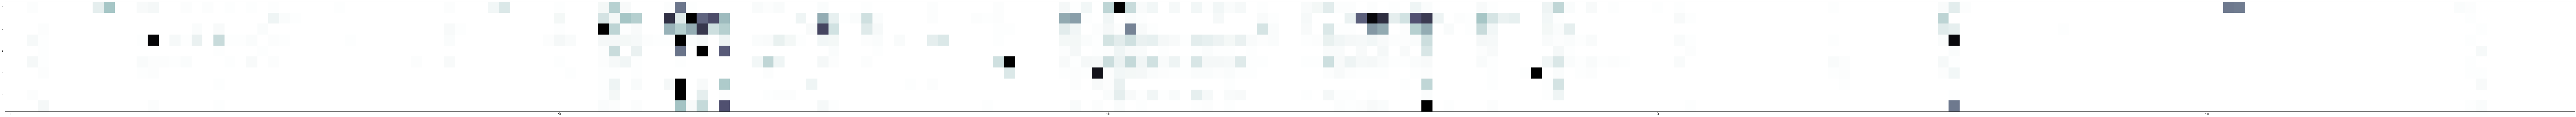

In [21]:
plt.figure(figsize=(200,20))
plt.imshow(new_norm_matrix,cmap='bone_r')
plt.savefig('/home/emilyjanedennis/Desktop/ratsigma_unsorted.eps')

In [21]:
location=pd.read_csv('/home/emilyjanedennis/Downloads/ManuscriptPrep_injections - summary.csv')
location=location[0:12]
plt.scatter(location.y.astype('int'),location.z.astype('int'))
plt.xlim([0,1150])
plt.ylim([0,618])
plt.savefig('/home/emilyjanedennis/Desktop/brains_in_mPRA.eps')

FileNotFoundError: [Errno 2] File b'/home/emilyjanedennis/Downloads/ManuscriptPrep_injections - summary.csv' does not exist: b'/home/emilyjanedennis/Downloads/ManuscriptPrep_injections - summary.csv'

In [22]:
sigma_in_mPRA = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/SIGMA_annotations_in_mPRA.tif')

In [23]:
np.shape(sigma_in_mPRA)

(618, 1150, 385)

NameError: name 'location' is not defined

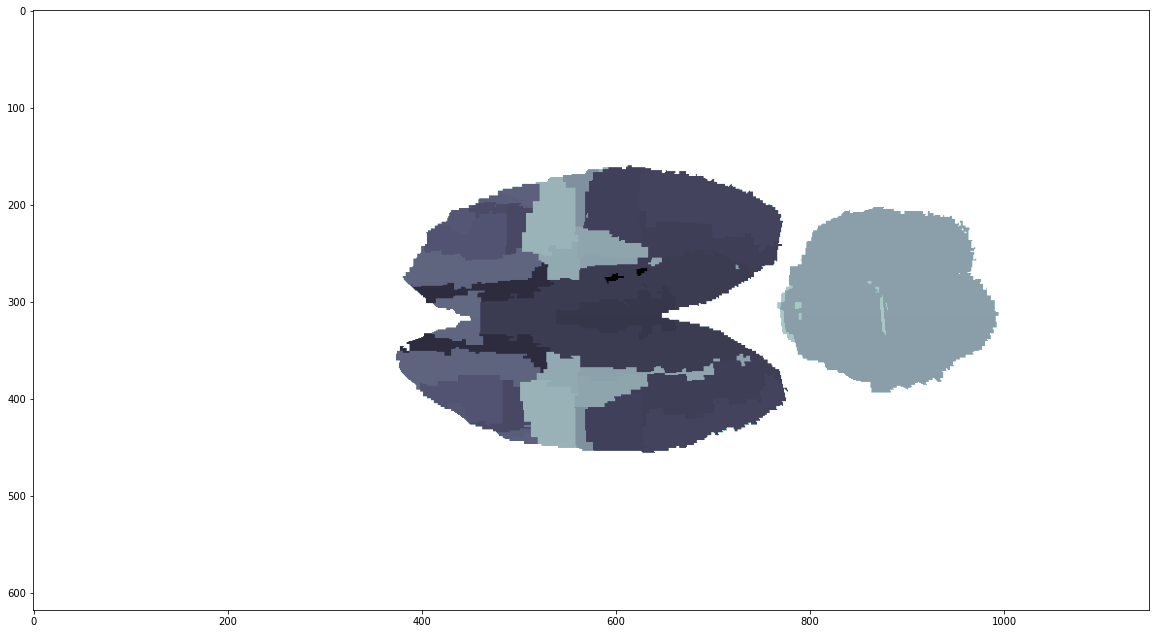

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(sigma_in_mPRA[:,:,46],cmap='bone_r')
location=location[0:12]
plt.scatter(location.y.astype('int'),location.z.astype('int'),c='k')
plt.savefig('/home/emilyjanedennis/Desktop/sigma_seg_inj_inmPRA.eps')

In [25]:
plt.figure(figsize=(20,20))
plt.imshow(mPRA_grid_masked[:,:,46],cmap='bone_r',clim=(500,2000))
location=location[0:12]
plt.scatter(location.y.astype('int'),location.z.astype('int'),c='k')
plt.savefig('/home/emilyjanedennis/Desktop/grid_seg_inj_inmPRA.eps')

NameError: name 'mPRA_grid_masked' is not defined

<Figure size 1440x1440 with 0 Axes>

In [23]:
all_cosines = get_cosine_matrix(new_norm_matrix)

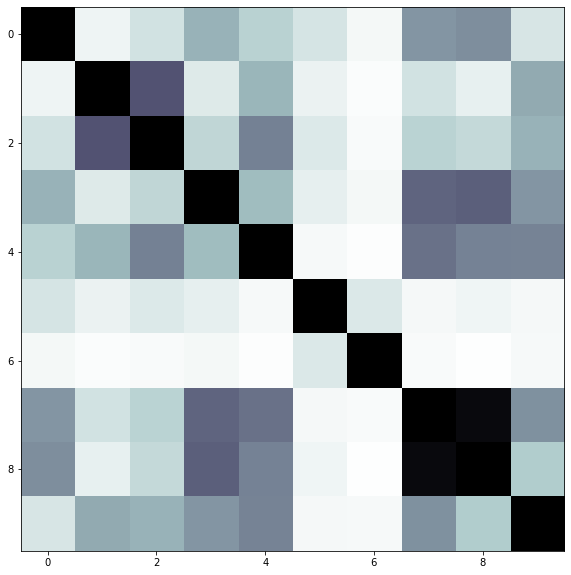

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(all_cosines,cmap="bone",clim=(0,1))
plt.savefig('/home/emilyjanedennis/Desktop/ratsigma_cosine_dists.eps')

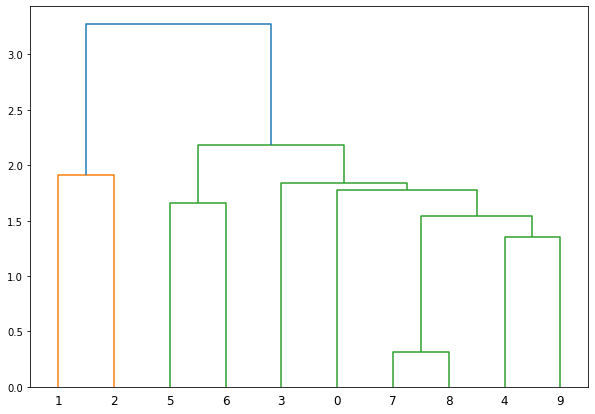

In [25]:
m='ward'
plt.figure(figsize=(10,7))
dend=shc.dendrogram(shc.linkage(new_norm_matrix,method=m))
order = dend['leaves']
plt.savefig('/home/emilyjanedennis/Desktop/ratsigma_tree-{}.eps'.format(m))
plt.show()

In [26]:
mat_for_plot = []
cos_for_plot=[]
new_matrix_names_sorted=[]
for n in order:
    print(new_matrix_names[n][:-1])
    new_matrix_names_sorted.append(new_matrix_names[n][:-1])
    mat_for_plot.append(new_norm_matrix[n])
    cos_for_plot.append(all_cosines[n]) 

z266
z268
M122
m128
e142
e144
z265
e153
j316
j319


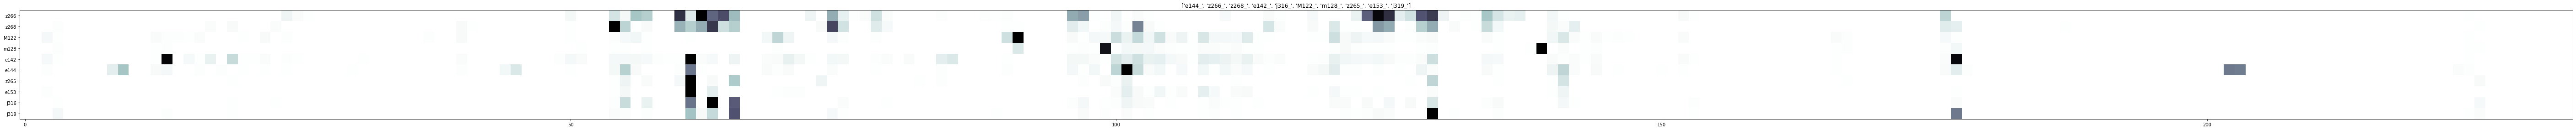

In [30]:
plt.figure(figsize=(100,20))
plt.imshow(mat_for_plot,clim=(0,1),cmap='bone_r')
plt.title(new_matrix_names)
plt.yticks(np.arange(0,len(new_matrix_names_sorted)),new_matrix_names_sorted)
plt.savefig('/home/emilyjanedennis/Desktop/ratsigma_sorted_hm.eps')

## rat in grid

In [31]:
mPRA = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/mPRA.tif')
np.shape(mPRA)

(618, 1150, 385)

In [34]:
# make grid brain or load
grid_size=30

if make_grid > 0:
    mPRA  = tif.imread(os.path.join(src,'for_registration_to_lightsheet/tiffs/mPRA.tif'))
    mPRA_grid = np.zeros(np.shape(mPRA))

    block_no = 0
    for zblock in np.arange(0,np.floor(np.shape(mPRA_grid)[2])/grid_size):
        zstart=int(zblock*grid_size)
        zend=int(zstart+grid_size)
        for yblock in np.arange(0,np.floor(np.shape(mPRA_grid)[1])/grid_size):
            ystart=int(yblock*grid_size)
            yend=int(ystart+grid_size)    
            for xblock in np.arange(0,np.floor(np.shape(mPRA_grid)[0])/grid_size):
                block_no+=1
                print(block_no)
                xstart=int(xblock*grid_size)
                xend=int(xstart+grid_size)
                mPRA_grid[xstart:xend,ystart:yend,zstart:zend]=block_no
    tif.imsave('/home/emilyjanedennis/Desktop/mPRA_{}_grid.tif'.format(grid_size),mPRA_grid.astype('uint16'))
else:
    mPRA_grid=tif.imread('/home/emilyjanedennis/Desktop/mPRA_{}_grid.tif'.format(grid_size))
    print('loaded mPRA grid from file')

loaded mPRA grid from file


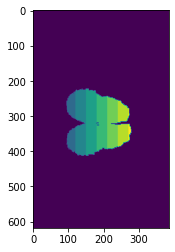

In [35]:
mPRA_mask=tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/SIGMA_annotations_in_mPRA.tif')
vals = []
for el in list_of_elements:    
    vals.extend(np.unique(mPRA_grid[mPRA_mask==el]))
    mPRA_mask[mPRA_mask==el]=0
mPRA_mask[mPRA_mask>0]=1
mPRA_grid_masked = np.multiply(mPRA_grid,mPRA_mask)
plt.imshow(mPRA_grid_masked[:,200,:])

# rat grid

In [37]:
if make_grid>0:
    grid_df=pd.DataFrame(np.unique(mPRA_grid_masked),columns=['grid_id'])
    grid_df.insert(1,'voxels',0)
    print(grid_df)

    for idx in grid_df.index:
        print(idx)
        grid_df.voxels[idx]=len(mPRA_grid_masked[mPRA_grid_masked==int(grid_df.grid_id[idx])])
else:
    grid_df=pd.read_csv('/home/emilyjanedennis/Desktop/PRA_grid_and_results.csv')
grid_df

,Unnamed: 0,Unnamed: 0.1,grid_id,z265,j316,m128,z266,j319,z268,e144,j317,z267,M122,e142,e153,voxels
0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,202940089
1,1,1,303,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,508
2,2,2,304,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.003086,324
3,3,3,306,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,78
4,4,4,307,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668,3668,3668,10201,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1437
3669,3669,3669,10221,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1306
3670,3670,3670,10222,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,2655
3671,3671,3671,10242,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,216


# 2021 11 22

In [38]:
if make_grid>0:
    bool_list=[]
    for nm in os.listdir(fld):
        if "bool" in nm and nm.lower()[0:4] in adj_names:
            bool_list.append(nm)
    print('bool list is {}'.format(bool_list))

    df_copy = grid_df.copy()

    for file in bool_list:
        print('file is {}'.format(file))
        valueslist=[0]
        vol = tif.imread(os.path.join(fld,file))
        for idx in df_copy.index[1:]:
            val = int(sum(vol[mPRA_grid_masked==df_copy.grid_id[idx]])/255)/df_copy.voxels[idx]
            valueslist.append(val)
        try:
            df_copy.insert(len(df_copy.columns)-1,file[0:4],valueslist)
        except:
            print('could not insert {}'.format(file[0:4]))
        df_copy.to_csv('/home/emilyjanedennis/Desktop/PRA_grid_and_results.csv')
        grid_df = df_copy.copy()
else:
    print('make_grid > 0, already made these')
    grid_df=pd.read_csv('/home/emilyjanedennis/Desktop/PRA_grid_and_results.csv')
grid_df


make_grid > 0, already made these


,Unnamed: 0,Unnamed: 0.1,grid_id,z265,j316,m128,z266,j319,z268,e144,j317,z267,M122,e142,e153,voxels
0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,202940089
1,1,1,303,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,508
2,2,2,304,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.003086,324
3,3,3,306,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,78
4,4,4,307,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668,3668,3668,10201,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1437
3669,3669,3669,10221,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1306
3670,3670,3670,10222,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,2655
3671,3671,3671,10242,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,216


In [39]:
df_30_rat_test=grid_df.drop(columns=['Unnamed: 0','Unnamed: 0.1','grid_id','voxels']).copy().transpose()
df_30_rat_matrix=df_30_rat_test.as_matrix()

rat_grid_matrix=[]
for row in df_30_rat_matrix.copy():
    rat_grid_matrix.append(np.divide(row,np.max(row)))
rat_norm_matrix = np.array(rat_grid_matrix)
#np.shape(rat_grid_matrix)


/tmp/ipykernel_5445/3414498177.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  df_30_rat_matrix=df_30_rat_test.as_matrix()


In [40]:
df_30_rat_test

,0,1,2,3,4,5,6,7,8,9,...,3663,3664,3665,3666,3667,3668,3669,3670,3671,3672
z265,0.0,0.0,0.000000,0.0,0.0,0.0,0.000175,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
j316,0.0,0.0,0.000000,0.0,0.0,0.0,0.000524,0.001025,0.0,0.001219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
m128,0.0,0.0,0.000000,0.0,0.0,0.0,0.000524,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
z266,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
j319,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
z268,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
e144,0.0,0.0,0.000000,0.0,0.0,0.0,0.001047,0.000769,0.0,0.084484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008449
j317,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
z267,0.0,0.0,0.000000,0.0,0.0,0.0,0.000349,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
M122,0.0,0.0,0.000000,0.0,0.0,0.0,0.000524,0.001538,0.0,0.005686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


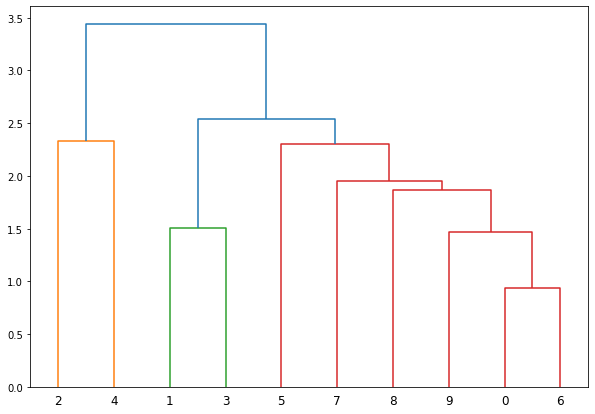

In [41]:
plt.figure(figsize=(10,7))
dend=shc.dendrogram(shc.linkage([rat_norm_matrix[i] for i in [0,1,3,4,5,6,7,8,10,11]],method='ward')) #weighted, ward, single
order = dend['leaves']
plt.savefig('/home/emilyjanedennis/Desktop/rat_linkage_grid.eps')

In [42]:
sub_index=[df_30_rat_test.index[i] for i in [0,1,3,4,5,6,7,8,10,11]]

In [43]:
sorted_grid_names=[sub_index[i] for i in order]
sorted_grid_names 

['z266',
 'z268',
 'j316',
 'j319',
 'e144',
 'z267',
 'e142',
 'e153',
 'z265',
 'j317']

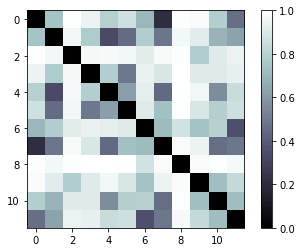

In [44]:
tst=get_cosine_matrix(rat_norm_matrix)
plt.imshow(tst,cmap='bone')
plt.clim(0,1)
plt.colorbar()
plt.show()

In [45]:
# now find closest RAT
cosine_list, cosine_to_plot = get_closest_vals(rat_norm_matrix[0],rat_norm_matrix)
print(cosine_list)

[0, 0.2091236234255941, 0.46128793855414263, 0.6969022816363877]
[ 0  7 11  6]


In [46]:
sorted_rat_grid = []
for n in order:
    sorted_rat_grid.append(rat_grid_matrix[n])
sorted_rat_grid = np.array(sorted_rat_grid)

In [47]:
np.shape(sorted_rat_grid)

(10, 3673)

In [48]:
sorted_grid_names

['z266',
 'z268',
 'j316',
 'j319',
 'e144',
 'z267',
 'e142',
 'e153',
 'z265',
 'j317']

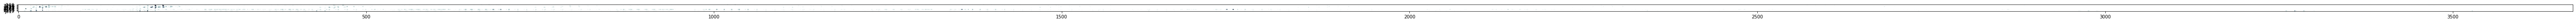

In [49]:
plt.figure(figsize=(100,30))
plt.imshow(np.array(sorted_rat_grid),cmap="bone_r")
plt.yticks(np.arange(0,10),sorted_grid_names)
plt.savefig('/home/emilyjanedennis/Desktop/rat_sorted_grid.eps')

In [50]:
rat_grp_b_med=np.median([sorted_rat_grid[i] for i in [2,3]],axis=0)
rat_grp_a_med=np.median([sorted_rat_grid[i] for i in [8,9]],axis=0)
rat_grp_med=np.median([sorted_rat_grid[i] for i in [4,5,6,7]],axis=0)

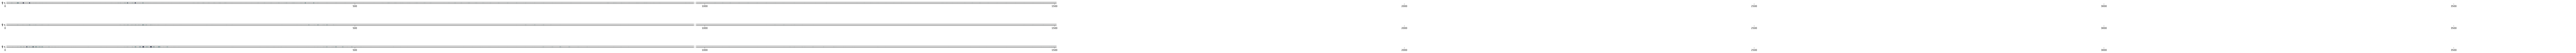

In [51]:
fig,axs=plt.subplots(3,1,figsize=(200,5),dpi=300)
axs[0].imshow([rat_grp_a_med,rat_grp_a_med],clim=(0,1),cmap='bone_r')
axs[1].imshow([rat_grp_med,rat_grp_med],clim=(0,1),cmap='bone_r')
axs[2].imshow([rat_grp_b_med,rat_grp_b_med],clim=(0,1),cmap='bone_r')
plt.savefig('/home/emilyjanedennis/Desktop/a_grp_b_grid.eps')

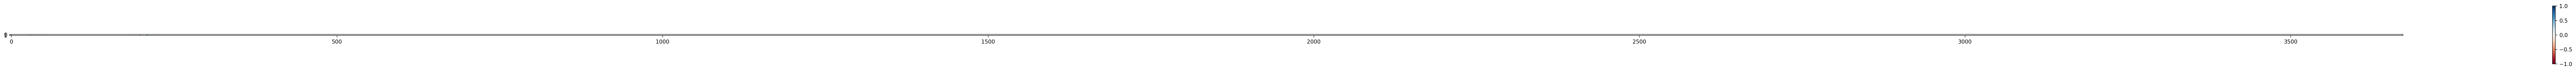

In [52]:
plt.figure(figsize=(100,2),dpi=200)
plt.imshow([rat_grp_a_med-rat_grp_med,rat_grp_b_med-rat_grp_med],clim=(-1,1),cmap='RdBu')
plt.colorbar()
plt.savefig('/home/emilyjanedennis/Desktop/a-grp_b-grp_grid.eps')

In [53]:
grp_a_grid_diffs=rat_grp_a_med-rat_grp_med
grp_b_grid_diffs=rat_grp_b_med-rat_grp_med




sigma_a=np.zeros(np.shape(sigma_in_mPRA))
sigma_b=np.zeros(np.shape(sigma_in_mPRA))

print('len is {}'.format(len(sigma_lab.ID)))
for i in np.arange(0,len(sigma_lab.ID)):
    print(i)
    sigma_id=int(sigma_lab.ID[i])
    sigma_a[sigma_in_mPRA==sigma_id]=grp_a_diffs[i]
    sigma_b[sigma_in_mPRA==sigma_id]=grp_b_diffs[i]
    

len is 234
0


NameError: name 'grp_a_diffs' is not defined

## grid and sigma make different predictions, which one looks right?

In [98]:
group_a=['e142','e153','z265','j317'] #sigma  2,3,5,4 #grid 8, 9 10, 11
group_grid_closer = ['e144','z267'] #sigma 8,9 #grid 6,7
group_sigma_closer = ['j316','j319'] #sigma 6,7  #grid 4, 5

In [101]:
new_matrix_names_sorted

['z268_',
 'z266_',
 'e142_',
 'e153_',
 'j317_',
 'z265_',
 'j316_',
 'j319_',
 'e144_',
 'z267_',
 'M122_',
 'm128_']

In [100]:
sorted_grid_names

['M122',
 'z266',
 'z268',
 'm128',
 'j316',
 'j319',
 'e144',
 'z267',
 'e142',
 'e153',
 'z265',
 'j317']

In [471]:
?plt.subplot

In [468]:
grp_a = np.median([mat_for_plot[i] for i in [2,3]],axis=0)
grp_b = np.median([mat_for_plot[i] for i in [8,9]],axis=0)
grp = np.median([mat_for_plot[i] for i in [5,4,6,7]],axis=0)

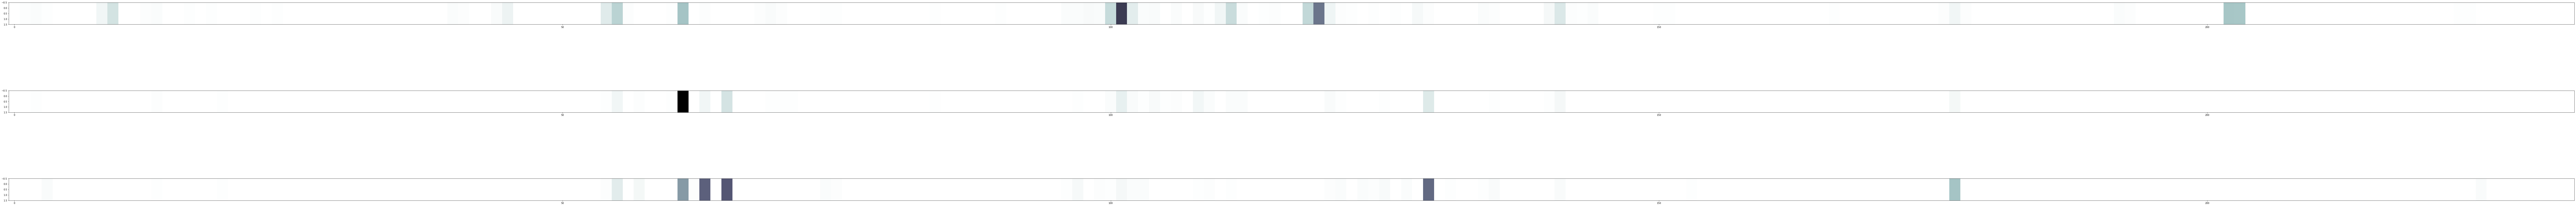

In [483]:
fig,axs=plt.subplots(3,1,figsize=(200,20))
axs[0].imshow([grp_a,grp_a],clim=(0,1),cmap='bone_r')
axs[1].imshow([grp,grp],clim=(0,1),cmap='bone_r')
axs[2].imshow([grp_b,grp_b],clim=(0,1),cmap='bone_r')
plt.savefig('/home/emilyjanedennis/Desktop/a_grp_b.eps')

ValueError: 'd' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [519]:
plt.figure(figsize=(200,20),dpi=200)
plt.imshow([grp_a-grp,grp_b-grp],clim=(-1,1),cmap='RdBu')
plt.colorbar()
plt.savefig('/home/emilyjanedennis/Desktop/a-grp_b-grp.eps')

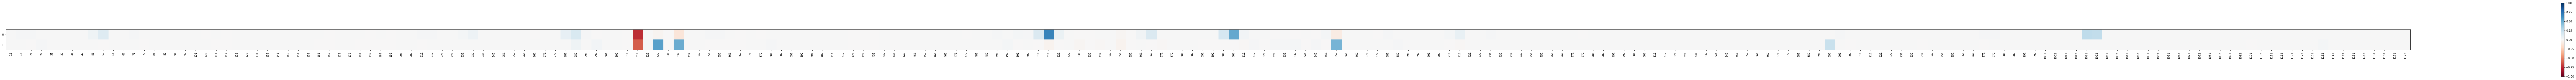

In [581]:
plt.figure(figsize=(200,5))
plt.imshow([grp_a-grp,grp_b-grp],clim=(-1,1),cmap='RdBu')
plt.xticks(np.arange(0,len(sigma_lab.ID)),sigma_lab.ID,rotation=90)
plt.colorbar()


In [587]:
grp_a_diffs=grp_a-grp
grp_b_diffs=grp_b-grp




sigma_a=np.zeros(np.shape(sigma_in_mPRA))
sigma_b=np.zeros(np.shape(sigma_in_mPRA))

print('len is {}'.format(len(sigma_lab.ID)))
for i in np.arange(0,len(sigma_lab.ID)):
    print(i)
    sigma_id=int(sigma_lab.ID[i])
    sigma_a[sigma_in_mPRA==sigma_id]=grp_a_diffs[i]
    sigma_b[sigma_in_mPRA==sigma_id]=grp_b_diffs[i]
    

len is 234
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


In [588]:
tif.imsave('/home/emilyjanedennis/Desktop/sigma_a.tif',sigma_a)
tif.imsave('/home/emilyjanedennis/Desktop/sigma_b.tif',sigma_b)

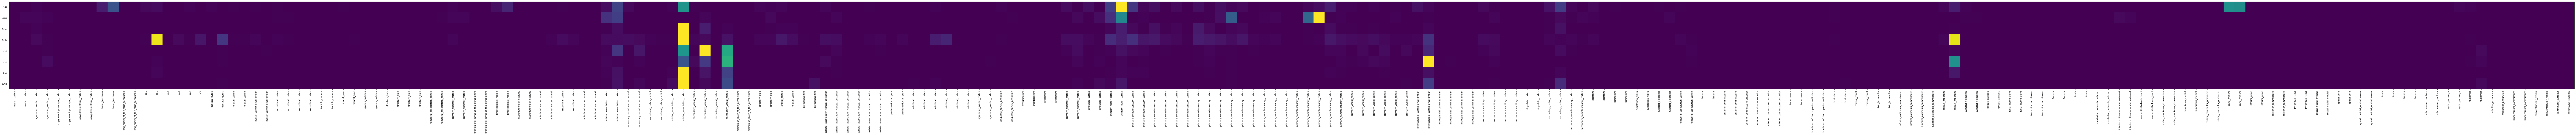

In [464]:
# sigma says: 4,5,6,7
plt.figure(figsize=(200,20))
plt.imshow([mat_for_plot[i] for i in [2,3,5,4,8,9,6,7]])
plt.yticks(np.arange(0,8),[new_matrix_names_sorted[i] for i in [2,3,5,4,8,9,6,7]])
plt.xticks(np.arange(0,len(sigma_lab.ID)),sigma_lab.common_name)
plt.xticks(rotation=90)

plt.show()

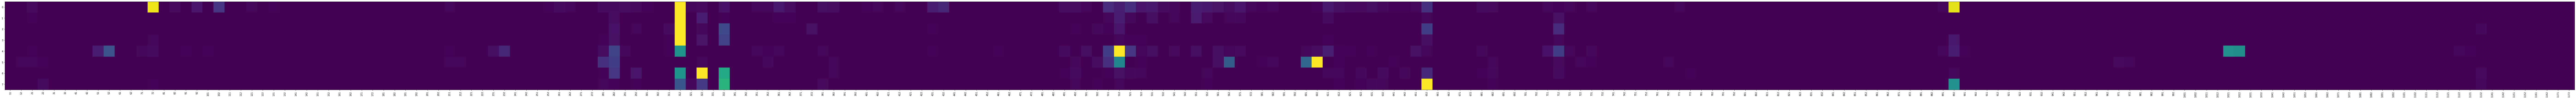

In [184]:
# sigma says: 4,5,6,7
plt.figure(figsize=(200,20))
plt.imshow([mat_for_plot[i] for i in [2,3,5,4,8,9,6,7]])
plt.xticks(np.arange(0,len(sigma_lab.ID)),sigma_lab.ID)
plt.xticks(rotation=90)

plt.show()

In [96]:
[sorted_grid_names[i] for i in []]

['j316', 'j317', 'z265', 'j319']

In [ ]:
plt.figure(figsize=(200,5))
plt.imshow([grp_a-grp,grp_b-grp],clim=(-1,1),cmap='RdBu')
plt.xticks(np.arange(0,len(sigma_lab.ID)),sigma_lab.common_name,rotation=90)
plt.colorbar()


In [525]:
sorted_grid_names

['z266',
 'z268',
 'j316',
 'j319',
 'e144',
 'z267',
 'e142',
 'e153',
 'z265',
 'j317']

In [527]:
np.shape(sorted_grid_names)

(10,)

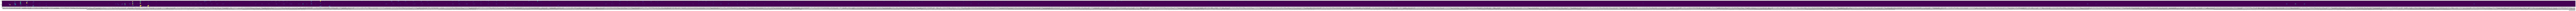

In [185]:
plt.figure(figsize=(500,20))
plt.imshow(np.array([sorted_rat_grid[i] for i in [8,9,10,11,6,7,4,5]]))
#plt.savefig('/home/emilyjanedennis/Desktop/rat_sorted_grid.eps')
plt.xticks(np.arange(0,len(grid_df.grid_id)),grid_df.grid_id,rotation=90)
plt.show()

In [593]:
rat_grp_a_diffs=rat_grp_a_med-rat_grp_med
rat_grp_b_diffs=rat_grp_b_med-rat_grp_med




grid_a=np.zeros(np.shape(mPRA_grid))
grid_b=np.zeros(np.shape(mPRA_grid))

print('len is {}'.format(len(grid_df.grid_id)))
for i in np.arange(0,len(grid_df.grid_id)):
    print(i)
    grid_id=int(grid_df.grid_id[i])
    grid_a[mPRA_grid==grid_id]=rat_grp_a_diffs[i]
    grid_b[mPRA_grid==grid_id]=rat_grp_b_diffs[i]
tif.imsave('/home/emilyjanedennis/Desktop/grid_a.tif',grid_a)
tif.imsave('/home/emilyjanedennis/Desktop/grid_b.tif',grid_b)

len is 3673
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
27

1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058


3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672


# how many voxels at what resolution do we want our allen data?

In [54]:
if make_grid > 0:
    # what size should we choose in the mouse 
    # to be reasonably similar to the rat?
    mg_allen = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/matlas_30_grid_in_Allen-template-sagittal.tif')
    val_list = []

    for val in np.unique(mg_allen):
        if val > 0:
            val_list.append(len(mg_allen[mg_allen==val]))
    mouse_val_list = val_lisT


    plt.hist([val for val in mouse_val_list if val < 20000 and val > 5000],bins=100)
    plt.show()

    mg_mpra=tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/matlas_grid_30_in_mPRA.tif')
    val_list = []

    for val in np.unique(mg_mpra):
        if val > 0:
            val_list.append(len(mg_mpra[mg_mpra==val]))
    plt.hist(val_list,bins=100)
    plt.show()
    rat_val_list = val_list

    plt.hist([val for val in rat_val_list if val < 60000 and val > 20000],bins=100)
    plt.xlim(30000,40000)
    plt.show()

    np.sqrt(15000)

    np.sqrt(32000)

    #want mouse to be about 20 (~3/4 of 30) vx^3 at 25 microns
else:
    print('skipping, already done')

skipping, already done


In [55]:
# make grid brain for mouse
make_grid = 0
if make_grid > 0:
    Allen = tif.imread(os.path.join(src,'for_registration_to_lightsheet/tiffs/Allen_annot_sagittal.tif'))
    Allen_grid = np.zeros(np.shape(Allen))

    grid_size=20
    block_no = 0
    for zblock in np.arange(0,np.floor(np.shape(Allen_grid)[2])/grid_size):
        zstart=int(zblock*grid_size)
        zend=int(zstart+grid_size)
        for yblock in np.arange(0,np.floor(np.shape(Allen_grid)[1])/grid_size):
            ystart=int(yblock*grid_size)
            yend=int(ystart+grid_size)    
            for xblock in np.arange(0,np.floor(np.shape(Allen_grid)[0])/grid_size):
                block_no+=1
                print(block_no)
                xstart=int(xblock*grid_size)
                xend=int(xstart+grid_size)
                Allen_grid[xstart:xend,ystart:yend,zstart:zend]=block_no
    tif.imsave('/home/emilyjanedennis/Desktop/Allen_{}_grid.tif'.format(grid_size),Allen_grid.astype('uint16'))

    Allen_mask=tif.imread(os.path.join(src,"for_registration_to_lightsheet/tiffs/Allen_annot_sagittal.tif"))
    Allen_mask[Allen_mask>0]=1
    Allen_grid_masked=np.multiply(Allen_mask,Allen_grid)

    Allen_grid_df=pd.DataFrame(np.unique(Allen_grid_masked),columns=['grid_id'])
    Allen_grid_df.insert(1,'voxels',0)
    for idx in Allen_grid_df.index:
        print(idx)
        Allen_grid_df.voxels[idx]=len(Allen_grid_masked[Allen_grid_masked==int(Allen_grid_df.grid_id[idx])])
    Allen_grid_for_seg=np.flipud(np.rot90(np.swapaxes(Allen_grid_masked,0,2)))
    tif.imsave('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/gridforseg.tif',Allen_grid_for_seg)
else:
    print('already made these')
    Allen_grid_for_seg = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/gridforseg.tif')


already made these


# get Allen data into shape

In [56]:
if make_grid > 0:
    # what size should we choose in the mouse 
    # to be reasonably similar to the rat?
    mg_allen = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/matlas_30_grid_in_Allen-template-sagittal.tif')
    val_list = []

    for val in np.unique(mg_allen):
        if val > 0:
            val_list.append(len(mg_allen[mg_allen==val]))
    mouse_val_list = val_lisT


    plt.hist([val for val in mouse_val_list if val < 20000 and val > 5000],bins=100)
    plt.show()

    mg_mpra=tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/matlas_grid_30_in_mPRA.tif')
    val_list = []

    for val in np.unique(mg_mpra):
        if val > 0:
            val_list.append(len(mg_mpra[mg_mpra==val]))
    plt.hist(val_list,bins=100)
    plt.show()
    rat_val_list = val_list

    plt.hist([val for val in rat_val_list if val < 60000 and val > 20000],bins=100)
    plt.xlim(30000,40000)
    plt.show()

    np.sqrt(15000)

    np.sqrt(32000)

    #want mouse to be about 20 (~3/4 of 30) vx^3 at 25 microns
else:
    print('skipping, already done')

skipping, already done


In [57]:
# make grid brain for mouse
if make_grid > 0:
    Allen = tif.imread(os.path.join(src,'for_registration_to_lightsheet/tiffs/Allen_annot_sagittal.tif'))
    Allen_grid = np.zeros(np.shape(Allen))

    grid_size=20
    block_no = 0
    for zblock in np.arange(0,np.floor(np.shape(Allen_grid)[2])/grid_size):
        zstart=int(zblock*grid_size)
        zend=int(zstart+grid_size)
        for yblock in np.arange(0,np.floor(np.shape(Allen_grid)[1])/grid_size):
            ystart=int(yblock*grid_size)
            yend=int(ystart+grid_size)    
            for xblock in np.arange(0,np.floor(np.shape(Allen_grid)[0])/grid_size):
                block_no+=1
                print(block_no)
                xstart=int(xblock*grid_size)
                xend=int(xstart+grid_size)
                Allen_grid[xstart:xend,ystart:yend,zstart:zend]=block_no
    tif.imsave('/home/emilyjanedennis/Desktop/Allen_{}_grid.tif'.format(grid_size),Allen_grid.astype('uint16'))

    Allen_mask=tif.imread(os.path.join(src,"for_registration_to_lightsheet/tiffs/Allen_annot_sagittal.tif"))
    Allen_mask[Allen_mask>0]=1
    Allen_grid_masked=np.multiply(Allen_mask,Allen_grid)

    Allen_grid_df=pd.DataFrame(np.unique(Allen_grid_masked),columns=['grid_id'])
    Allen_grid_df.insert(1,'voxels',0)
    for idx in Allen_grid_df.index:
        print(idx)
        Allen_grid_df.voxels[idx]=len(Allen_grid_masked[Allen_grid_masked==int(Allen_grid_df.grid_id[idx])])
    Allen_grid_for_seg=np.flipud(np.rot90(np.swapaxes(Allen_grid_masked,0,2)))
    tif.imsave('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/gridforseg.tif',Allen_grid_for_seg)
else:
    print('already made these')
    Allen_grid_for_seg = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/gridforseg.tif')


already made these


In [58]:
# import allen data
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json')
all_experiments = mcc.get_experiments(dataframe=True)

In [59]:

if make_grid > 0:
    # suggest running this as a script, provided in src
    x=-1
    dict_of_injs={}
    save_tiff=0

    for expid in all_experiments.id:
        x=x+1
        print('on {} id {}'.format(x,expid))
        p_d,pd_info=mcc.get_projection_density(expid)
        inj_mask,ind_info = mcc.get_injection_density(expid)
        dm,dm_info=mcc.get_data_mask(expid)

        dm[dm>0.5]=1
        inj_mask[inj_mask>0]=1

        #make a projection density that only has non-inj, valid vx
        new_pd=np.multiply(np.multiply(p_d,np.invert(inj_mask.astype('bool'))),dm)
        #save
        if save_tiff == 1:
            tif.imsave('/home/emilyjanedennis/Desktop/allens/projection_density_valid-noninj_{}.tif'.format(expid),new_pd)
            print('saved tiff')
        else:
            print('did not save tiff')
        # add info to df
        #for this experiment, which grids were injected?
        np.save('/home/emilyjanedennis/Desktop/allens/vector_inj_{}.npy'.format(expid),np.unique(Allen_grid_for_seg[inj_mask==False]))
        print('saved vector of inj')
        # for this experiment, make and save a vector with all the Allen grids'info
        grid_vector=[]
        for grid_id in np.unique(Allen_grid_for_seg):
            grid_vector.append(np.sum(new_pd[Allen_grid_for_seg==grid_id]))
        np.save('/home/emilyjanedennis/Desktop/allens/vector_proj_{}.npy'.format(expid),grid_vector)
        print('saved vector of proj')
else:
    print('skipping, already done')


skipping, already done


In [63]:
if make_grid>0:
    vector_fld = '/home/emilyjanedennis/Desktop/allens'
    expids=[]
    grid_inj_sites=[]
    proj_mat=[]
    # for each expid, get vectors
    for expid in all_experiments.id:
        files = [file for file in os.listdir(vector_fld) if str(expid) in file]
        # for each vector, determine if its proj or inj
        for file in files:
            if "proj" in file:
                proj_vect=np.load(os.path.join(vector_fld,file))
            #elif "inj" in file:
                inj_z=int(np.floor(np.divide(all_experiments.injection_z[expid],25)))
                inj_y=int(np.floor(np.divide(all_experiments.injection_y[expid],25)))
                inj_x=int(np.floor(np.divide(all_experiments.injection_x[expid],25)))
                grid_inj_site = Allen_grid_for_seg[inj_x,inj_y,inj_z]
                expids.append(expid)
                grid_inj_sites.append(grid_inj_site)
                proj_mat.append(np.divide(proj_vect,np.max(proj_vect)))
    np.save('/home/emilyjanedennis/Desktop/proj_mat.npy',proj_mat)
    np.save('/home/emilyjanedennis/Desktop/grid_inj_sites.npy',grid_inj_sites)
else:
    proj_mat=np.load('/home/emilyjanedennis/Desktop/proj_mat.npy')
    print('loaded from file')

In [64]:
# make transpose of the matrix, so we can grab rows instead of columns
grid_id_val=-1
transposed_mat = np.array(proj_mat).transpose()
len_for_vect = len(transposed_mat)
Allen_grid_ids=np.unique(Allen_grid_for_seg)
inj_grid_mat=[]

# for each gridid, pull that column of the matrix (now a row)
for row in transposed_mat:
    grid_id_val=grid_id_val+1
    print(grid_id_val)
    # now make two zeros vectors of len(grid ids)
    inj_grids=np.zeros(len_for_vect)
    inj_grid_counts=np.ones(len_for_vect)
    # get the elements of the vector where proj density is > 0
    exp_indices_with_value=[idx for idx, element in enumerate(row) if element>0]
    values_for_exp_indices=[element for idx, element in enumerate(row) if element>0]
    # now get the grid 
    for i in np.arange(0,len(exp_indices_with_value)):
        grid_value=int(grid_inj_sites[exp_indices_with_value[i]])
        grid_idx=int([idx for idx,element in enumerate(Allen_grid_ids) if element==grid_value][0])
        inj_grids[grid_idx]+=values_for_exp_indices[i]
        inj_grid_counts[grid_idx]+=1
    inj_grid_mat.append(np.divide(inj_grids,inj_grid_counts))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [65]:
norm_inj_grid_mat=[]
for row in inj_grid_mat:
    row[np.isnan(row)]=0
    norm_inj_grid_mat.append(np.divide(row,np.max(row)))
norm_inj_grid_mat=np.array(norm_inj_grid_mat)

In [66]:
np.save('/home/emilyjanedennis/Desktop/norm_inj_grid_mat.npy',norm_inj_grid_mat)

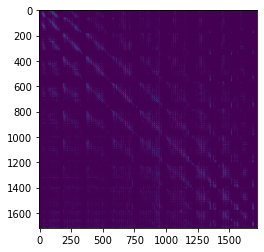

In [248]:
plt.imshow(norm_inj_grid_mat)

### now, make ANTEROGRADE segmentation, similarity plots

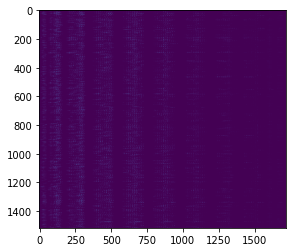

In [249]:
# first just get PPC adjacent regions

# get all grid vals in our (giant) ROI
cropped_grid_vals=np.unique(Allen_grid_for_seg[150:420,0:150,20:430])

# get all indices with grid vals in our ROI
inj_list_idx=[idx for idx, element in enumerate(grid_inj_sites) if element in cropped_grid_vals]

# now use this to subset the matrix
sub_proj_mat=[proj_mat[i] for i in inj_list_idx]
sub_expids=[expids[i] for i in inj_list_idx]
sub_inj_sites=[grid_inj_sites[i] for i in inj_list_idx]
plt.imshow(sub_proj_mat)

# get all grid IDX vals from grid vals
# cropped_grid_idx=[idx for idx,element in enumerate(Allen_grid_ids) if element in cropped_grid_vals]

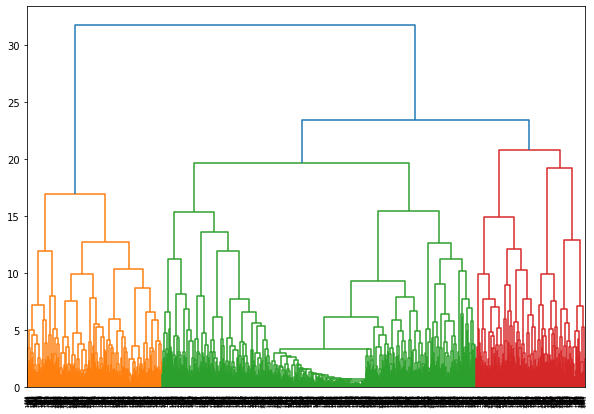

In [250]:
m='ward'
plt.figure(figsize=(10,7))
dend=shc.dendrogram(shc.linkage(sub_proj_mat,method=m))
order = dend['leaves']
plt.show()
ant_order=order

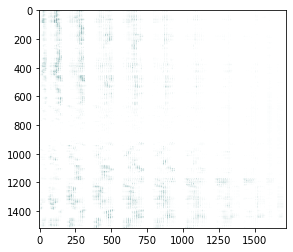

In [251]:
plt.imshow([sub_proj_mat[i] for i in order],cmap='bone_r')

In [252]:
sub_cos_mat=get_cosine_matrix([sub_proj_mat[i] for i in order])

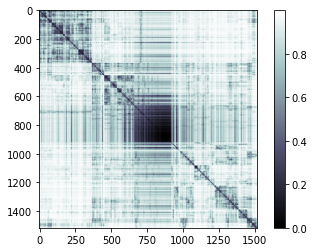

In [253]:
plt.imshow(sub_cos_mat,cmap='bone')
plt.colorbar()

In [254]:
sub_inj_sites_ordered=[sub_inj_sites[i] for i in order]

In [255]:
grid_3d_copy=np.zeros(np.shape(Allen_grid_for_seg))
sub_grid_freq=[]
for el in Allen_grid_ids:
    if sub_inj_sites_ordered[67:84].count(int(el)) > 0:
        grid_3d_copy[Allen_grid_for_seg==int(el)]=sub_inj_sites_ordered[800:910].count(int(el))

In [188]:
tif.imsave('/home/emilyjanedennis/Desktop/gridtest.tif',grid_3d_copy)
# awesome, we get things that make sense. injections in the same place, group together both by cosine similarity and by wards

## now make centered RETROGRADE segmentation, similarity plots

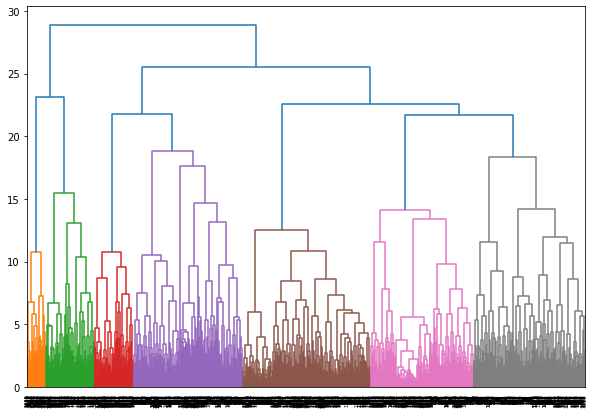

In [67]:
m='ward'
plt.figure(figsize=(10,7))
dend=shc.dendrogram(shc.linkage(norm_inj_grid_mat,method=m))
order = dend['leaves']
plt.show()
ret_order=order

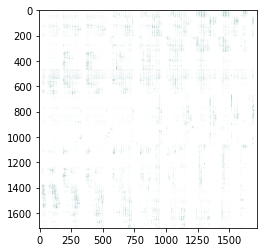

In [68]:
plt.imshow([norm_inj_grid_mat[i] for i in ret_order],cmap='bone_r')

In [69]:
ret_center_cos_mat=get_cosine_matrix([norm_inj_grid_mat[i] for i in order])

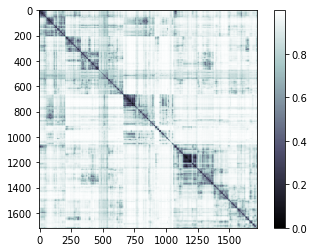

In [70]:
plt.imshow(ret_center_cos_mat,cmap='bone')
plt.colorbar()
plt.show()

In [71]:
real_allen = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/Allen_annot.tif')

In [389]:
print(7740/25)
print(1390/25)
print(3330/25)
#7740 	1390 	3330
#312782560

309.6
55.6
133.2


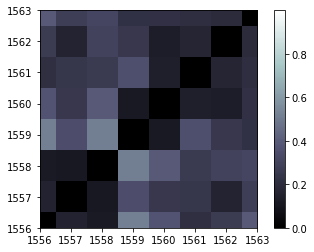

In [423]:
s1, s2 = (1556,1563)
plt.imshow(ret_center_cos_mat,cmap='bone')
plt.xlim(s1,s2)
plt.ylim(s1,s2)
plt.colorbar()
plt.show()

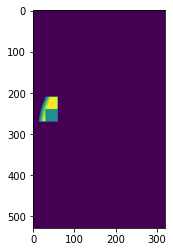

In [424]:
gridlist=[Allen_grid_ids[i] for i in order]
grid_3d_copy=np.zeros(np.shape(Allen_grid_for_seg))
sub_grid_freq=[]
for el in Allen_grid_ids:
    if gridlist[s1:s2].count(int(el)) > 0:
        grid_3d_copy[Allen_grid_for_seg==int(el)]=gridlist[s1:s2].count(int(el))
plt.imshow(np.sum(grid_3d_copy,axis=2))

In [1]:
gridlist[s1:s2]

NameError: name 'gridlist' is not defined

In [442]:
VISam_brain=np.zeros(np.shape(Allen_grid_for_seg))
VISam_ids=[281,1066,401,433,1046,441]
for val in VISam_ids:
    VISam_brain[real_allen==val]=1
VISam_grids = np.multiply(VISam_brain,Allen_grid_for_seg)

In [444]:
np.unique(VISam_grids)

array([  0., 149., 150., 154., 155., 165., 166., 170., 171., 438., 442.,
       443., 453., 454., 458., 459.])

In [ ]:
# make ALL GRID RETROGRADE data structures

In [ ]:
# make ALL GRID RETROGRADE segmentation, similarity plots

# mouserat

In [76]:
matlas_in_mPRA = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/matlas_grid_30_in_mPRA.tif')
df_30 = pd.read_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/grid_with_vx.csv')

In [74]:
# get rat in matlas
# take bool cell volumes, segment, make vector
fld_of_bool = '/home/emilyjanedennis/Desktop/ratmouse'
vect_out = '/home/emilyjanedennis/Desktop/ratmouse_output'
mouse_expids_in_matlas = pd.read_csv('/home/emilyjanedennis/Desktop/2021_raritan/df_30.csv')


In [258]:
if not os.path.isdir(vect_out):
    os.mkdir(vect_out)
    
for file in [file for file in os.listdir(fld_of_bool) if 'bool_cell' in file]:
    print(file)
    t = np.divide(tif.imread(os.path.join(fld_of_bool,file)),255)
    tif.imsave(os.path.join(vect_out,file),np.multiply(t,matlas_in_mPRA))

# get mouse data in  matlas
# have expid and expression ANTEROGRADE
mouse_expids_in_matlas = pd.read_csv('/home/emilyjanedennis/Desktop/2021_raritan/df_30.csv')
# drop extra columns and make into matrix with rows 

j316_cell_bool_cell_volume.tif
e142_cell_bool_cell_volume.tif
m128_cell_bool_cell_volume.tif
j319_cell_bool_cell_volume.tif
z268_cell_bool_cell_volume.tif
e144_cell_bool_cell_volume.tif
e153_cell_bool_cell_volume.tif
z266_cell_bool_cell_volume.tif
z265_cell_bool_cell_volume.tif
z267_cell_bool_cell_volume.tif
j317_cell_bool_cell_volume.tif
M122_cell_bool_cell_volume.tif


In [72]:
# drop extra columns and make into matrix with rows 


In [77]:
grid_id=283
mat=tif.imread(os.path.join(vect_out,'j316_cell_bool_cell_volume.tif'))
len(mat[matlas_in_mPRA==int(grid_id)])

237

In [ ]:
df_30
vect_grid_vals=[]
df_30_rat=df_30.copy()
for file in [file for file in os.listdir(vect_out) if ".tif" in file][2:]:
    mat=tif.imread(os.path.join(vect_out,file))
    for i in np.arange(0,len(df_30.grid_id)):
        grid_id=df_30.grid_id[i]
        vect_grid_vals.append(np.divide(len(mat[matlas_in_mPRA==int(grid_id)]),int(df_30.voxels[i])))
        df_30.insert(2,file[0:4],vect_grid_vals)

In [112]:
file=[file for file in os.listdir(vect_out) if ".tif" in file][0]
mat=tif.imread(os.path.join(vect_out,file))
print(file)
vect_grid_vals=[]
    for i in np.arange(0,len(df_30.grid_id)):
        grid_id=df_30.grid_id[i]
        vect_grid_vals.append(np.divide(np.count_nonzero(mat[matlas_in_mPRA==int(df_30.grid_id[i])]),int(df_30.voxels[i])))

IndentationError: unexpected indent (3225264417.py, line 5)

In [114]:
df_30
df_30_rat=df_30.copy()
for file in [file for file in os.listdir(vect_out) if ".tif" in file]:
    mat=tif.imread(os.path.join(vect_out,file))
    vect_grid_vals=[]
    for i in np.arange(0,len(df_30.grid_id)):
        grid_id=df_30.grid_id[i]
        if grid_id==0:
            vect_grid_vals.append(0)
        else:
            vect_grid_vals.append(np.divide(np.count_nonzero(mat[matlas_in_mPRA==int(df_30.grid_id[i])]),int(df_30.voxels[i])))
    try:
        df_30_rat.insert(2,file[0:4],vect_grid_vals)
    except:
        print('did not insert {}'.format(file[0:4]))
    np.save(os.path.join(vect_out,'vect_{}'.format(file[0:4])),vect_grid_vals)

In [116]:
df_30_rat.to_csv('/home/emilyjanedennis/Desktop/df_30_rat_12062021.csv')

In [ ]:
# TODO 0 finish getting rat in matlas space by normalizing above df info

In [118]:
df_30_rat=df_30_rat.drop(columns=['Unnamed: 0'])

In [120]:
df_30_rat_norm = pd.DataFrame(df_30_rat.grid_id)
for col_nm in df_30_rat.columns:
    print(col_nm)
    if col_nm not in ['grid_id','voxels']:
        df_30_rat_norm.insert(1,col_nm,np.divide(df_30_rat[col_nm],np.max(df_30_rat[col_nm])))
df_30_rat_norm

grid_id
M122
j317
z267
z265
z266
e153
e144
z268
j319
m128
e142
j316
voxels


,grid_id,j316,e142,m128,j319,z268,e144,e153,z266,z265,z267,j317,M122
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
1,281.0,0.0,0.000000,0.0,0.0,0.0,0.164337,0.0,0.0,0.000000,0.0,0.000000,0.0
2,282.0,0.0,0.061751,0.0,0.0,0.0,0.192892,0.0,0.0,0.308045,0.0,0.097309,0.0
3,283.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.103563,0.0,0.000000,0.0
4,299.0,0.0,0.000000,0.0,0.0,0.0,0.006439,0.0,0.0,0.053987,0.0,0.402114,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2644,6272.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
2645,6273.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
2646,6274.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
2647,6291.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0


In [ ]:
# make/get mouse data in matlas

In [361]:
mouse_expids_in_matlas[mouse_expids_in_matlas.index==0]=0 #ignore vx outside regions

In [122]:
mouse_expids_in_matlas

,Unnamed: 0,grid_id,272824561,113400134,117317884,180073473,127710392,307297141,180917660,174360333,...,125361005,272782668,159648854,121509711,180981417,158314987,584903636,304762965,e142,e144
0,0,0,0.250513,0.343712,0.245685,0.237778,0.409313,0.849981,0.991254,0.701043,...,0.560569,0.811509,1.000000,1.000000,0.27718,0.953905,1.000000,0.263982,174232309,173175430
1,1,281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.057291,0.000000,0.00000,0.000853,0.000000,0.000000,0,22
2,2,282,0.000000,0.000000,0.000000,0.008119,0.233962,0.002749,0.000000,0.002744,...,0.000000,0.028657,0.205427,0.000000,0.00000,0.146861,0.000057,0.000000,0,597
3,3,283,0.000000,0.000074,0.000341,0.006761,0.176016,0.040153,0.000000,0.006656,...,0.000000,0.000000,0.052029,0.000000,0.00000,0.142180,0.000880,0.000000,0,5
4,4,299,0.000000,0.000000,0.000000,0.017345,0.169399,0.179310,0.000000,0.043239,...,0.000000,0.059270,0.078923,0.002492,0.00000,0.097557,0.008550,0.004754,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2644,2644,6272,0.000000,0.000000,0.000499,0.000000,0.001386,0.000008,0.000000,0.000538,...,0.000000,0.000000,0.009283,0.020275,0.00005,0.000621,0.008878,0.000000,0,0
2645,2645,6273,0.018866,0.000000,0.026181,0.000000,0.000000,0.002698,0.000000,0.008812,...,0.000000,0.001204,0.013984,0.001704,0.00000,0.000000,0.000000,0.007153,0,0
2646,2646,6274,0.000184,0.000000,0.000000,0.000000,0.002922,0.004579,0.000000,0.030877,...,0.000000,0.003422,0.064689,0.000000,0.08639,0.004128,0.000000,0.000000,0,0
2647,2647,6291,0.002714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0,0


In [123]:
mouse_expids_in_matlas=mouse_expids_in_matlas.drop(columns=['Unnamed: 0','e142','e144','grid_id','voxels'])

In [125]:
mouse_matlas_expids = mouse_expids_in_matlas.columns
mouse_matlas_expids

Index(['272824561', '113400134', '117317884', '180073473', '127710392',
       '307297141', '180917660', '174360333', '100140949', '156978574',
       ...
       '126523066', '304564721', '125361005', '272782668', '159648854',
       '121509711', '180981417', '158314987', '584903636', '304762965'],
      dtype='object', length=419)

In [126]:
df_30_mouse_matrix=mouse_expids_in_matlas.as_matrix().transpose()

mouse_matrix_in_matlas=[]
for row in df_30_mouse_matrix.copy():
    mouse_matrix_in_matlas.append(np.divide(row,np.max(row)))
mouse_norm_matrix = np.array(mouse_matrix_in_matlas)
#np.shape(rat_grid_matrix)


/tmp/ipykernel_5445/1263180238.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  df_30_mouse_matrix=mouse_expids_in_matlas.as_matrix().transpose()


In [159]:
df_30_rat

,grid_id,M122,j317,z267,z265,z266,e153,e144,z268,j319,m128,e142,j316,voxels
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,123996592
1,281.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.130435,0.0,0.0,0.0,0.000000,0.0,23
2,282.0,0.0,0.069259,0.0,0.009721,0.0,0.0,0.153098,0.0,0.0,0.0,0.021871,0.0,823
3,283.0,0.0,0.000000,0.0,0.003268,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,306
4,299.0,0.0,0.286201,0.0,0.001704,0.0,0.0,0.005111,0.0,0.0,0.0,0.000000,0.0,587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2644,6272.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,993
2645,6273.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,972
2646,6274.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,140
2647,6291.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1


In [183]:
df_30_rat.drop(columns=['grid_id','voxels','M122','m128']).columns

Index(['j317', 'z267', 'z265', 'z266', 'e153', 'e144', 'z268', 'j319', 'e142',
       'j316'],
      dtype='object')

In [181]:
df_30_rat_matrix=df_30_rat.drop(columns=['grid_id','voxels','M122','m128']).as_matrix().transpose()

rat_matrix_in_matlas=[]
for row in df_30_rat_matrix.copy():
    rat_matrix_in_matlas.append(np.divide(row,np.max(row)))
rat_matrix_in_matlas = np.array(rat_matrix_in_matlas)
np.shape(rat_matrix_in_matlas)


/tmp/ipykernel_5445/1696091559.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  df_30_rat_matrix=df_30_rat.drop(columns=['grid_id','voxels','M122','m128']).as_matrix().transpose()


(10, 2649)

In [163]:
# need to subset rat matrix to rm columns where grid_id doesn't exist in mouse expids in matlas

In [164]:
rat_matrix_in_matlas

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.06175076, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.09730904, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [199]:
vect_num = 0
col_nms=df_30_rat.drop(columns=['grid_id','voxels','M122','m128']).columns

In [204]:
print('rat is {}'.format(col_nms[vect_num]))

vect=rat_matrix_in_matlas[vect_num]
matrix_for_comparison=rat_matrix_in_matlas

list_of_cosines=[]
for val in matrix_for_comparison:
    list_of_cosines.append(spd.cosine(vect,val))
cosine_sorted_indices = np.argsort(list_of_cosines)
cosine_sorted = list_of_cosines.copy()
cosine_sorted.sort()
num_cosines_to_plot = int(np.sum([np.array(cosine_sorted) < 0.15]))

# get closest rat 
if num_cosines_to_plot < 2:
    num_cosines_to_plot=2
cosine_list = cosine_sorted_indices[0:num_cosines_to_plot]
print(cosine_sorted[0:num_cosines_to_plot])
print(cosine_sorted_indices[0:2])
rat_cosine_to_plot=[matrix_for_comparison[val] for val in cosine_sorted_indices[0:int(num_cosines_to_plot)]]
second_vect=cosine_sorted_indices[1]
print('closest rat is {}'.format(col_nms[second_vect]))


matrix_for_comparison=mouse_matrix_in_matlas

list_of_cosines=[]
for val in matrix_for_comparison:
    list_of_cosines.append(spd.cosine(vect,val))
cosine_sorted_indices = np.argsort(list_of_cosines)
cosine_sorted = list_of_cosines.copy()
cosine_sorted.sort()
num_cosines_to_plot = int(np.sum([np.array(cosine_sorted) < 0.5]))

# get four closest mice
if num_cosines_to_plot < 4:
    num_cosines_to_plot=4
cosine_list = cosine_sorted_indices[0:num_cosines_to_plot]
print(cosine_sorted[0:num_cosines_to_plot])
print(cosine_sorted_indices[0:4])
cosine_to_plot=[matrix_for_comparison[val] for val in cosine_sorted_indices[0:int(num_cosines_to_plot)]]

#make into fx
vect=rat_matrix_in_matlas[second_vect]

list_of_cosines=[]
for val in matrix_for_comparison:
    list_of_cosines.append(spd.cosine(vect,val))
cosine_sorted_indices = np.argsort(list_of_cosines)
cosine_sorted = list_of_cosines.copy()
cosine_sorted.sort()
num_cosines_to_plot = int(np.sum([np.array(cosine_sorted) < 0.5]))

# get four closest mice
if num_cosines_to_plot < 4:
    num_cosines_to_plot=4
second_cosine_list = cosine_sorted_indices[0:num_cosines_to_plot]
print(cosine_sorted[0:num_cosines_to_plot])
print(cosine_sorted_indices[0:4])
second_cosine_to_plot=[matrix_for_comparison[val] for val in cosine_sorted_indices[0:int(num_cosines_to_plot)]]


rat is j317
[0, 0.2931532408809854]
[0 2]
closest rat is z265
[0.6575700478742865, 0.7623676495241922, 0.8083573064455958, 0.8127500511343706]
[183 160 196 184]
[0.7199362245582566, 0.7753624168822569, 0.7887251411533268, 0.8001185496155612]
[183 160 184  47]


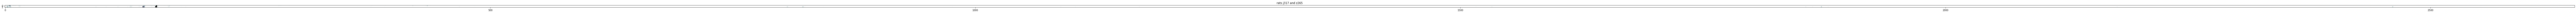

In [202]:
plt.figure(figsize=(200,20))
plt.imshow(rat_cosine_to_plot,cmap='bone_r')
plt.title('rats {} and {}'.format(col_nms[vect_num],col_nms[second_vect]))
plt.show()

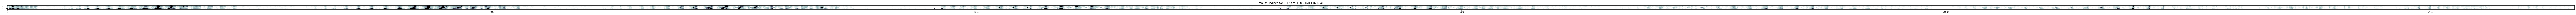

In [206]:
plt.figure(figsize=(200,20))
plt.imshow(cosine_to_plot,cmap='bone_r')
plt.title('mouse indices for {} are: {}'.format(col_nms[vect_num],cosine_list)) # get list of grid vals, use instead
plt.show()

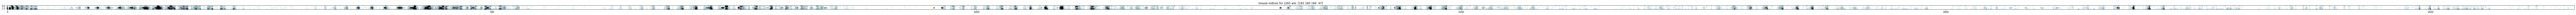

In [208]:
plt.figure(figsize=(200,20))
plt.imshow(second_cosine_to_plot,cmap='bone_r')
plt.title('mouse indices for {} are: {}'.format(col_nms[second_vect],second_cosine_list)) # get list of grid vals, use instead
plt.show()

In [ ]:
# old

In [260]:
if make_grid>0:
    vector_fld = '/home/emilyjanedennis/Desktop/allens'
    expids=[]
    grid_inj_sites=[]
    proj_mat=[]
    # for each expid, get vectors
    for expid in all_experiments.id:
        files = [file for file in os.listdir(vector_fld) if str(expid) in file]
        # for each vector, determine if its proj or inj
        for file in files:
            if "proj" in file:
                proj_vect=np.load(os.path.join(vector_fld,file))
            #elif "inj" in file:
                inj_z=int(np.floor(np.divide(all_experiments.injection_z[expid],25)))
                inj_y=int(np.floor(np.divide(all_experiments.injection_y[expid],25)))
                inj_x=int(np.floor(np.divide(all_experiments.injection_x[expid],25)))
                grid_inj_site = Allen_grid_for_seg[inj_x,inj_y,inj_z]
                expids.append(expid)
                grid_inj_sites.append(grid_inj_site)
                proj_mat.append(np.divide(proj_vect,np.max(proj_vect)))
    np.save('/home/emilyjanedennis/Desktop/proj_mat.npy',proj_mat)
    
    # make transpose of the matrix, so we can grab rows instead of columns
    grid_id_val=-1
    transposed_mat = np.array(proj_mat).transpose()
    len_for_vect = len(transposed_mat)
    Allen_grid_ids=np.unique(Allen_grid_for_seg)
    inj_grid_mat=[]

    # for each gridid, pull that column of the matrix (now a row)
    for row in transposed_mat:
        grid_id_val=grid_id_val+1
        print(grid_id_val)
        # now make two zeros vectors of len(grid ids)
        inj_grids=np.zeros(len_for_vect)
        inj_grid_counts=np.ones(len_for_vect)
        # get the elements of the vector where proj density is > 0
        exp_indices_with_value=[idx for idx, element in enumerate(row) if element>0]
        values_for_exp_indices=[element for idx, element in enumerate(row) if element>0]
        # now get the grid 
        for i in np.arange(0,len(exp_indices_with_value)):
            grid_value=int(grid_inj_sites[exp_indices_with_value[i]])
            grid_idx=int([idx for idx,element in enumerate(Allen_grid_ids) if element==grid_value][0])
            inj_grids[grid_idx]+=values_for_exp_indices[i]
            inj_grid_counts[grid_idx]+=1
        inj_grid_mat.append(np.divide(inj_grids,inj_grid_counts))
    np.save('/home/emilyjanedennis/Desktop/inj_grid_mat.npy',inj_grid_mat)
else:
    proj_mat=np.load('/home/emilyjanedennis/Desktop/proj_mat.npy')
    print('loaded from file')



loaded from file
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
2

# z265/j317

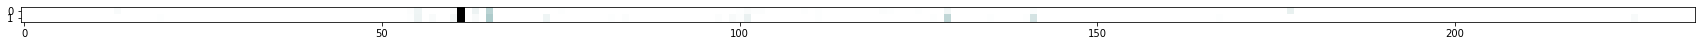

In [42]:
plt.figure(figsize=(30,10))
plt.imshow(mat_for_plot[4:6],cmap='bone_r',clim=(0,1))
plt.savefig('/home/emilyjanedennis/Desktop/j317_z265_hm.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


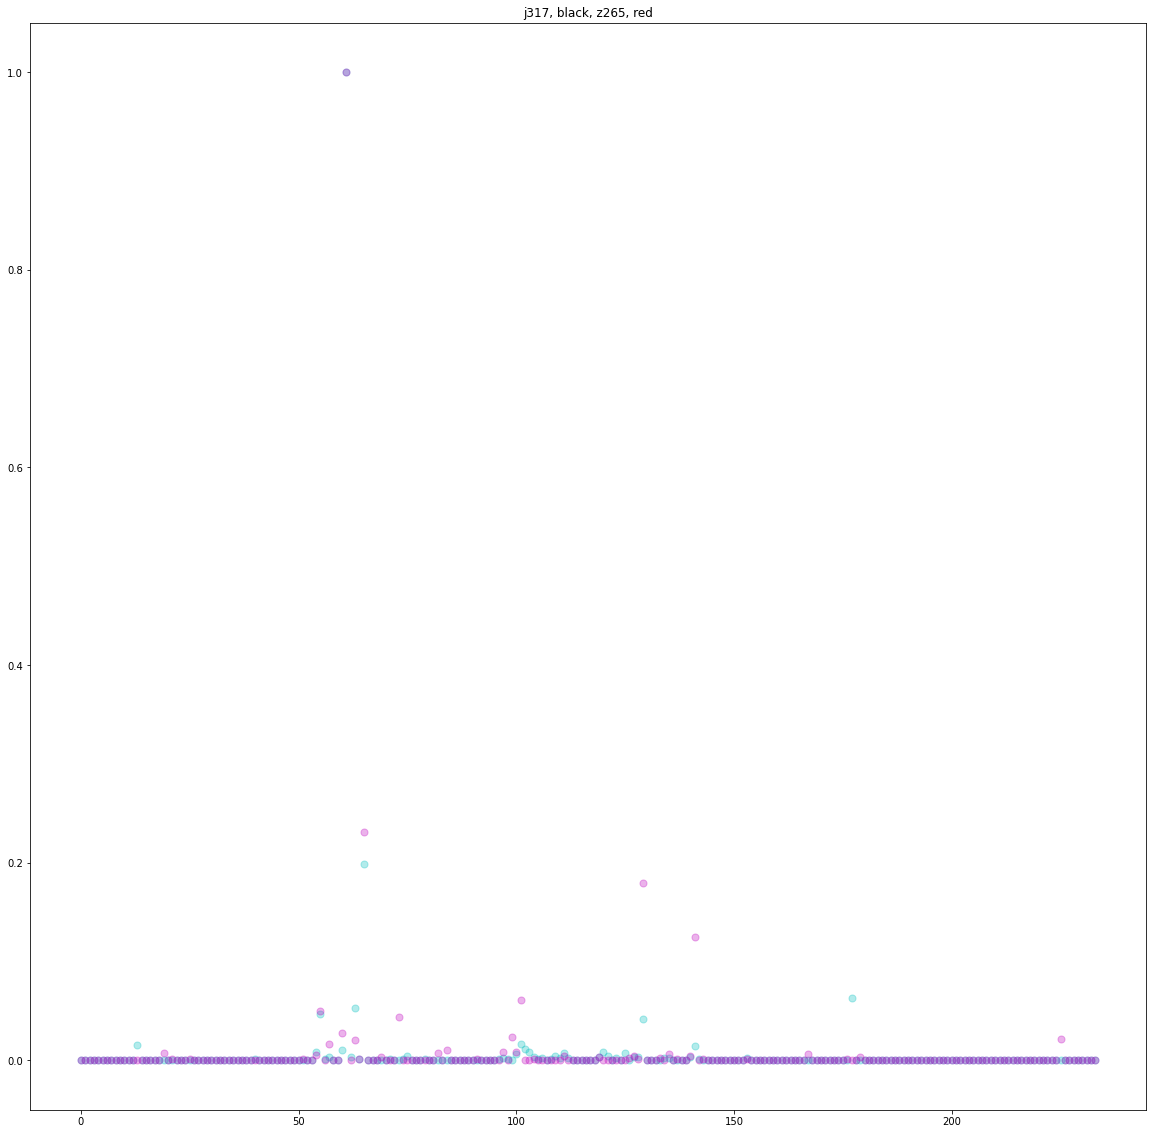

In [43]:
plt.figure(figsize=(20,20))
plt.scatter(np.arange(0,len(mat_for_plot[4])),mat_for_plot[4],s=50,c='c',alpha=0.3)
plt.scatter(np.arange(0,len(mat_for_plot[5])),mat_for_plot[5],s=50,c='m',alpha=0.3)

plt.title('j317, black, z265, red')
plt.savefig('/home/emilyjanedennis/Desktop/j317_z265.eps')
plt.show()

In [27]:
if make_grid > 0:
    sigma_lab.insert(2,'j317_counts',new_norm_matrix[7])
    sigma_lab.insert(2,'z265_counts',new_norm_matrix[8])
    
    sigma_tiff = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/SIGMA_annotations_in_mPRA.tif')
    j317_in_sigma = np.zeros(np.shape(sigma_tiff))
    z265_in_sigma = np.zeros(np.shape(sigma_tiff))

    for idx in sigma_lab.index:
        print(idx)
        z265_in_sigma[sigma_tiff==int(sigma_lab.ID[idx])]=sigma_lab.z265_counts[idx]
        j317_in_sigma[sigma_tiff==int(sigma_lab.ID[idx])]=sigma_lab.j317_counts[idx]
    tif.imsave('/home/emilyjanedennis/Desktop/z265_in_sigma_16.tif',z265_in_sigma.astype('uint16'))
    tif.imsave('/home/emilyjanedennis/Desktop/j317_in_sigma_16.tif',j317_in_sigma.astype('uint16'))
else:
    print('already made these tiffs')

already made these tiffs


In [28]:
loc_vals=[]
adj_names=[]
for nm in new_matrix_names:
    name = nm[:-1].lower()
    print(name)
    adj_names.append(name)
    for row_num in location.index:
        if name in location.injectionID[row_num].lower():
             loc_vals.append([location.z[row_num],location.y[row_num],location.x[row_num]])

e144
z267
z268
e142
j316
z266
m122
j317
z265
m128
e153
j319


In [29]:
loc_dists=[]
loc_dist_this=[]
for i in np.arange(0,len(loc_vals)):
    row=loc_vals[i]
    loc_dist_this=[]
    for comp_row in loc_vals:
        loc_dist_this.append(np.sqrt(np.sum((np.asarray(comp_row,dtype='uint16')-np.asarray(row,dtype='uint16'))**2, axis=0)))
    loc_dists.append(loc_dist_this)

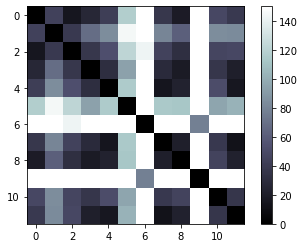

In [30]:
plt.imshow(loc_dists,cmap='bone',clim=(0,150))
plt.colorbar()
plt.savefig('/home/emilyjanedennis/Desktop/physical_dists.eps')